# Noise2Void - 2D Example for RGB Data

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

Using TensorFlow backend.


# Download Example Data
Original clean photograph is by Eric Fredericks published on Flickr under CC license: https://creativecommons.org/licenses/by-sa/2.0/.
Our modified noisy version is under the same license.

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/RGB.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/Frru2hsjjAljpfW/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

# Training Data Preparation
For training, we will load __one__ low-SNR RGB image and use the <code>N2V_DataGenerator</code> to extract non-overlapping patches.

In [3]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [4]:
# We will load all the '.png' files from the 'data' directory. In our case it is only one.
# The function will return a list of images (numpy arrays).
# In the 'dims' parameter we specify the order of dimensions in the image files we are reading:
# 'C' stands for channels (color)
imgs = datagen.load_imgs_from_directory(directory="data/", filter='*.png', dims='YXC')

# Let's look at the shape of the image
print('shape of loaded images: ',imgs[0].shape)
# The function automatically added an extra dimension to the image.
# It is used to hold a potential stack of images, such as a movie.
# The image has four color channels (stored in the last dimension): RGB and Aplha.
# We are not interested in Alpha and will get rid of it.
imgs[0] = imgs[0][...,:3]
print('shape without alpha:    ',imgs[0].shape)

shape of loaded images:  (1, 1100, 2800, 4)
shape without alpha:     (1, 1100, 2800, 3)


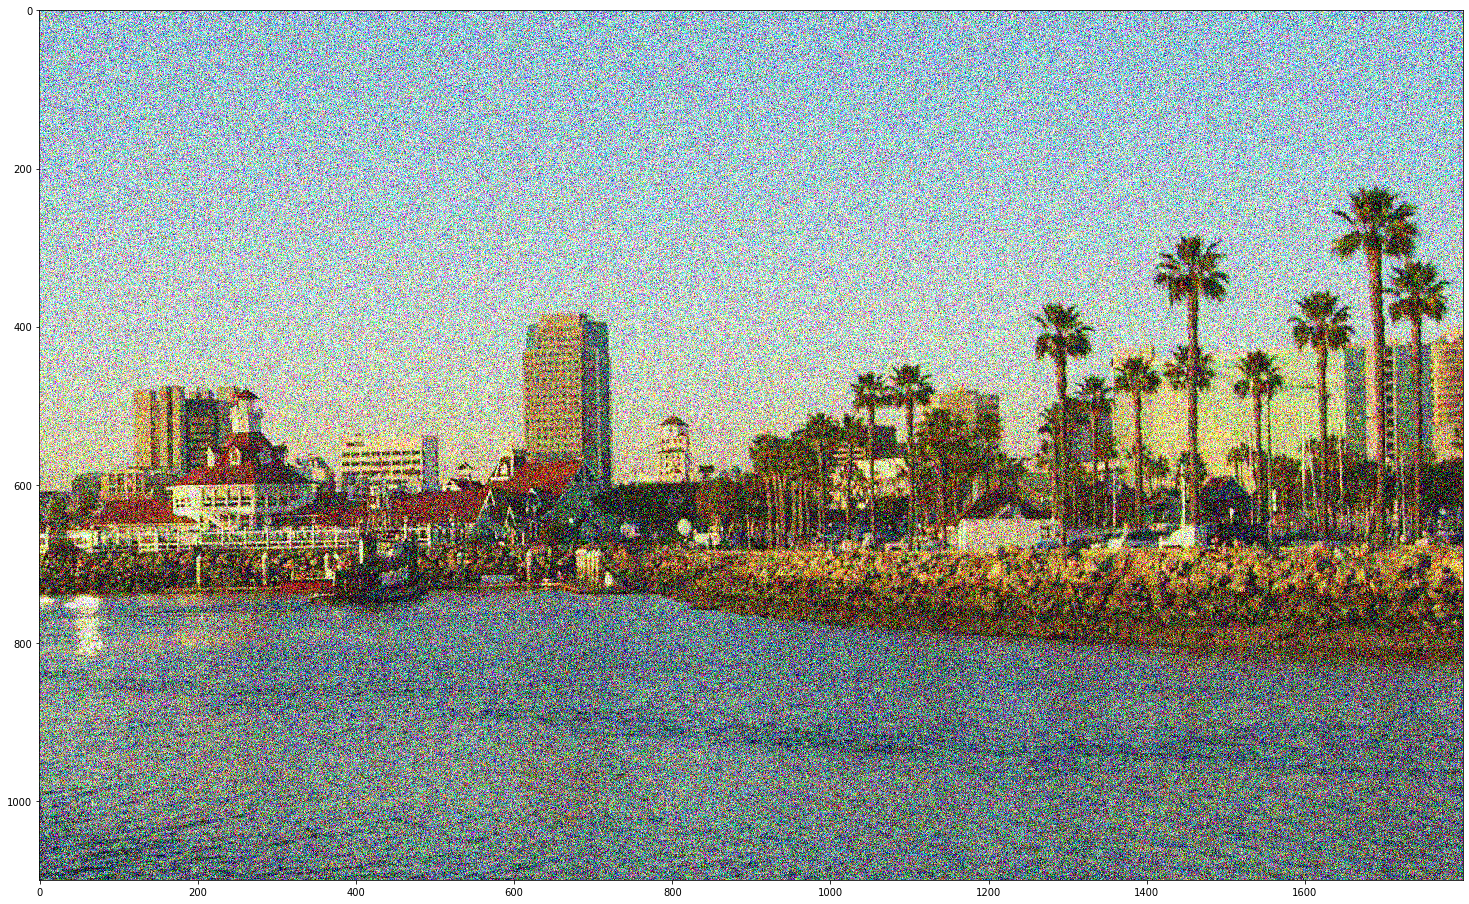

In [5]:
# Let's look at the image.
# We have to remove the added extra dimension to display it as 2D image.
plt.figure(figsize=(32,16))
plt.imshow(imgs[0][0,:,1000:3000,...])
plt.show()

In [6]:
# Next we extract patches for training and validation.
# The parameter 'shape' defines the size of these patches.
patches = datagen.generate_patches_from_list(imgs, shape=(64,64))

Generated patches: (5848, 64, 64, 3)


In [7]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
X = patches[:5000]
X_val = patches[5000:]

In [8]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

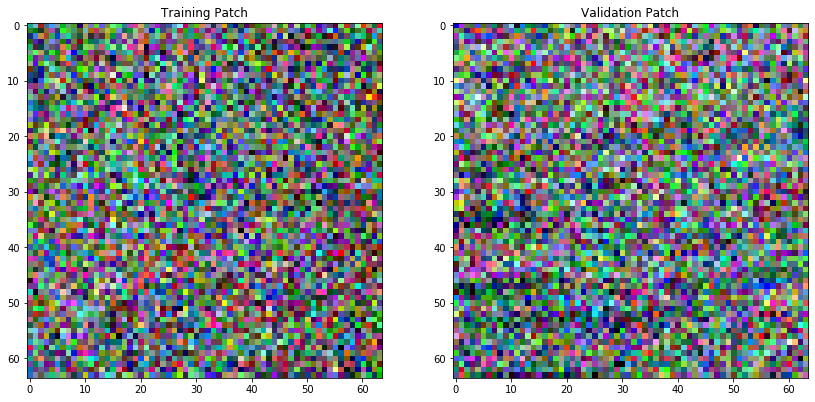

In [9]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');

# Configure

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
Compared to working with single channel data, we also recommend to use a deeper network with more feature channels.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 25. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [10]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
config = N2VConfig(X, unet_kern_size=3, 
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/128), train_epochs=25, train_loss='mse', 
                   batch_norm=True, train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['0.5514884', '0.5928719', '0.5711972'],
 'stds': ['0.29422635', '0.3017542', '0.31599146'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 25,
 'train_steps_per_epoch': 39,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'probabilistic': False}

In [11]:
# a name used to identify the model --> change this to something sensible!
model_name = 'n2v_2D'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [12]:
history = model.train(X, X_val)

Preparing validation data:   0%|          | 0/848 [00:00<?, ?it/s]

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 848/848 [00:00<00:00, 1727.75it/s]


Epoch 1/25
39/39 [==============================] - 15s 397ms/step - loss: 1.0864 - n2v_mse: 1.0864 - n2v_abs: 0.8337 - val_loss: 2.3912 - val_n2v_mse: 2.3912 - val_n2v_abs: 1.1229
Epoch 2/25
39/39 [==============================] - 10s 267ms/step - loss: 0.6354 - n2v_mse: 0.6354 - n2v_abs: 0.6545 - val_loss: 0.7048 - val_n2v_mse: 0.7048 - val_n2v_abs: 0.6776
Epoch 3/25
39/39 [==============================] - 10s 263ms/step - loss: 0.6363 - n2v_mse: 0.6363 - n2v_abs: 0.6568 - val_loss: 0.6670 - val_n2v_mse: 0.6670 - val_n2v_abs: 0.6668
Epoch 4/25
39/39 [==============================] - 10s 264ms/step - loss: 0.6334 - n2v_mse: 0.6334 - n2v_abs: 0.6557 - val_loss: 0.7102 - val_n2v_mse: 0.7102 - val_n2v_abs: 0.6800
Epoch 5/25
39/39 [==============================] - 11s 271ms/step - loss: 0.6331 - n2v_mse: 0.6331 - n2v_abs: 0.6546 - val_loss: 0.6330 - val_n2v_mse: 0.6330 - val_n2v_abs: 0.6566
Epoch 6/25
39/39 [==============================] - 10s 263ms/step - loss: 0.6283 - n2v_mse: 0.

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


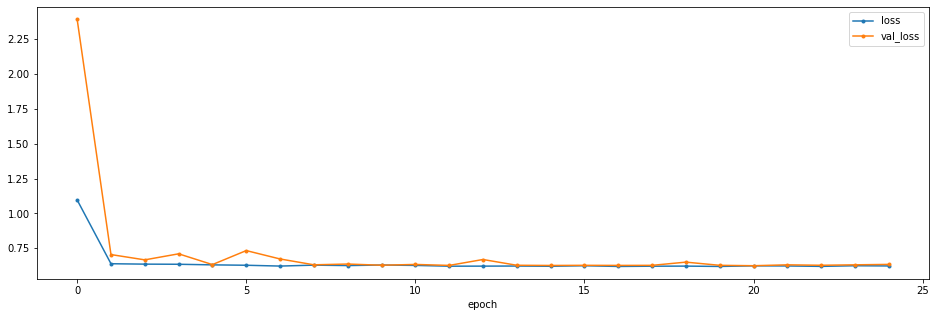

In [13]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model to be Used with CSBDeep Fiji Plugins and KNIME Workflows
See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [ ]:
model.export_TF()